# Mask R-CNN - part 2

Before you start:
 - Clone Mask_RCNN, install dependencies https://github.com/matterport/Mask_RCNN
 - Download weights of COCO model https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
 - Download COCO dataset from http://cocodataset.org/#download or at least the adnotations https://vision.ece.vt.edu/mscoco/coco/annotations/instances_train-val2014.zip

## Paths

Remember to change to your own...

In [1]:
import os

ROOT_DIR = os.path.abspath("../../varia/Mask_RCNN/")
MODEL_DIR = os.path.abspath("/data/coco/")
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")

## Libraries

In [2]:
import sys
import random
import math

import numpy as np
import skimage.io

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
"""Import Mask R-CNN."""
sys.path.append(ROOT_DIR)
import mrcnn.utils
import mrcnn.model
import mrcnn.visualize

Using TensorFlow backend.


## Configuration

In [4]:
"""Load the configuration file for the MS-COCO model."""
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))
import coco


class InferenceConfig(coco.CocoConfig):
    """Owerwrite the batch size.
    
    Batch size = GPU_COUNT * IMAGES_PER_GPU
    For our needs, we need batch size = 1
    """
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.3

    
config = InferenceConfig()

In [5]:
"""Create a model object and load the weights."""
model = mrcnn.model.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [6]:
"""Check class numbers."""
dataset = coco.CocoDataset()
dataset.load_coco(MODEL_DIR, "train")
dataset.prepare()

loading annotations into memory...
Done (t=9.39s)
creating index...
index created!


## Times Square example

In [7]:
"""Load a image."""
IMAGE = os.path.abspath("../resources/images/time_square.jpeg")
image = skimage.io.imread(IMAGE)
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (442, 878, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


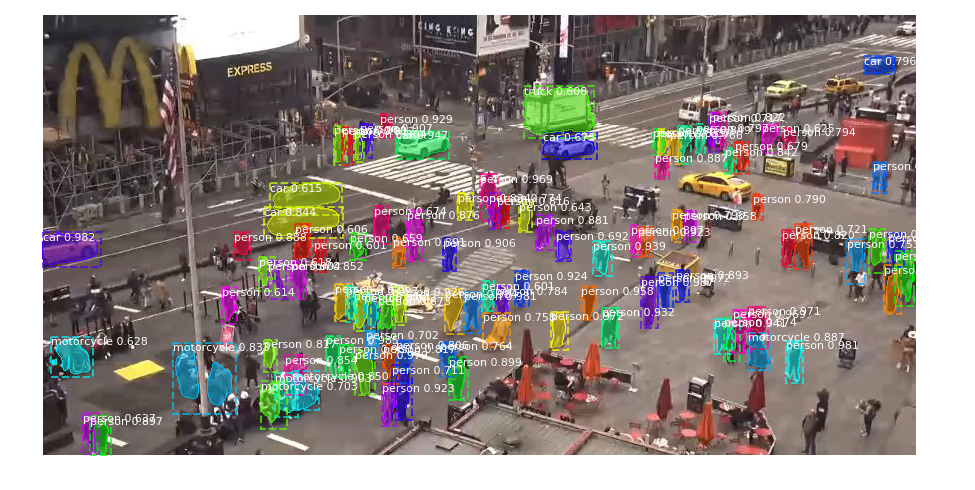

In [8]:
"""Visualize results."""
r = results[0]

mrcnn.visualize.display_instances(
    image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

## Filtering vehicles

In [9]:
def filter_vehicles(detected_objects):
    """Skip boxes that do not indicate cars, buses or trucks.
    
    Cuco models ids are:
     - 3 car,
     - 4 motorcycle,
     - 6 bus,
     - 7 train,
     - 8 truck,
     - 9 boat.
    """
    mask = np.array([i in (3, 8, 6) for i in detected_objects['class_ids']], dtype=bool)
    
    vehicles = {
        'rois': detected_objects['rois'][mask],
        'class_ids': detected_objects['class_ids'][mask],
        'scores': detected_objects['scores'][mask],
        'masks': detected_objects['masks'][:,:,mask]
    }
    
    return vehicles

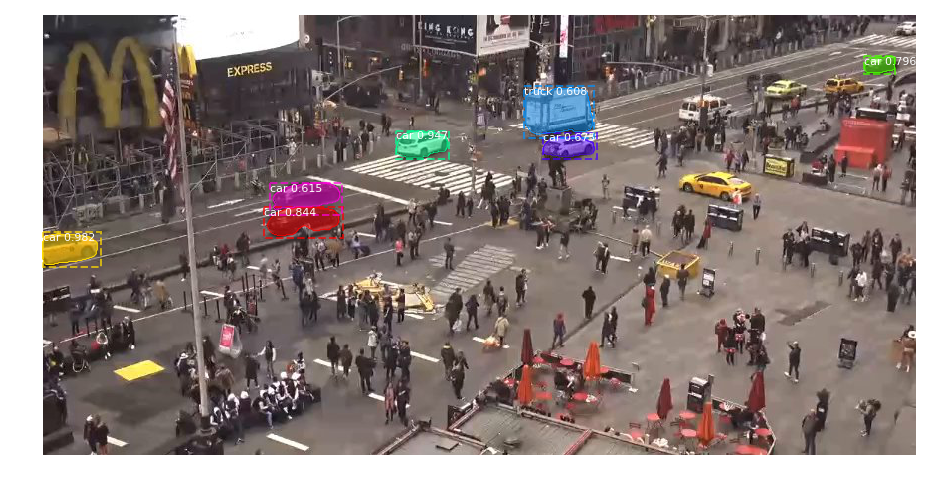

In [10]:
"""Visualize results."""
r = results[0]
r = filter_vehicles(r)

mrcnn.visualize.display_instances(
    image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

In [11]:
"""Return how many vehicles we detected."""
len(r['class_ids'])

7

## Small parking lot example

In [12]:
"""Load a image."""
IMAGE = os.path.abspath("../resources/images/parking_lot_small.jpg")
image = skimage.io.imread(IMAGE)
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


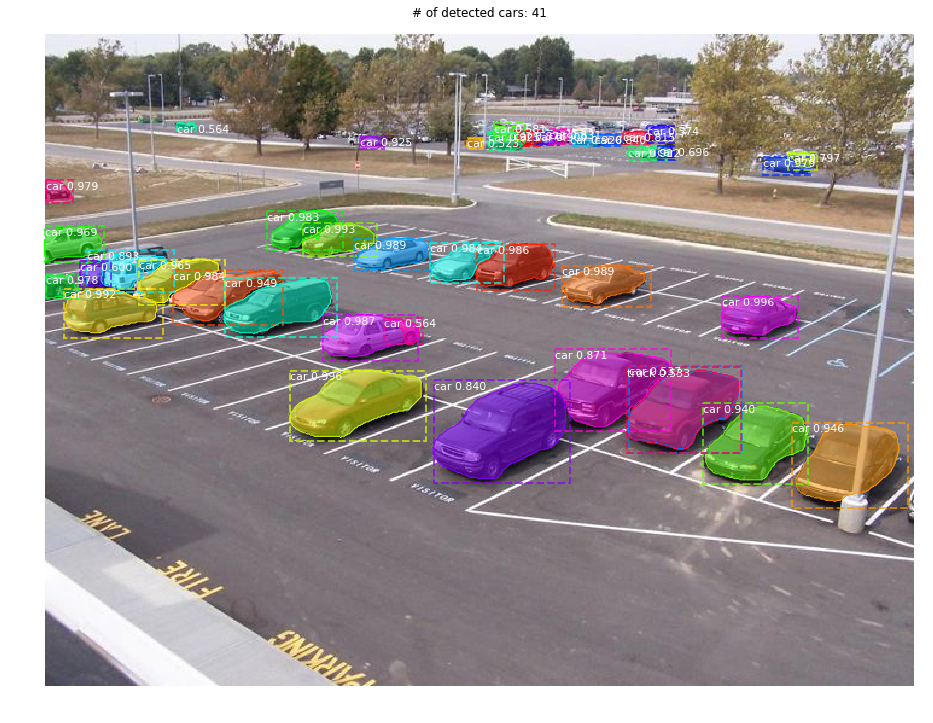

In [13]:
"""Visualize results."""
r = results[0]
r = filter_vehicles(r)

mrcnn.visualize.display_instances(
    image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'],
    title='# of detected cars: {}'.format(len(r['class_ids'])))

In [14]:
"""Return how many cars we detected."""
len(r['class_ids'])

41

## Filtering cars in the background

In [15]:
def filter_small_vehicles(detected_objects, treshold=0.01):
    """Skip boxes that are small."""
    size = lambda x: (x[2]-x[0])*(x[3]-x[1])
    size_x, size_y, _ = detected_objects['masks'].shape
    min_size = size_x*size_y*treshold
    
    mask = np.array([size(i) > min_size for i in detected_objects['rois']], dtype=bool)
    
    vehicles = {
        'rois': detected_objects['rois'][mask],
        'class_ids': detected_objects['class_ids'][mask],
        'scores': detected_objects['scores'][mask],
        'masks': detected_objects['masks'][:,:,mask]
    }
    
    return vehicles

In [16]:
"""Return how many cars we detected."""
len(r['class_ids'])

41

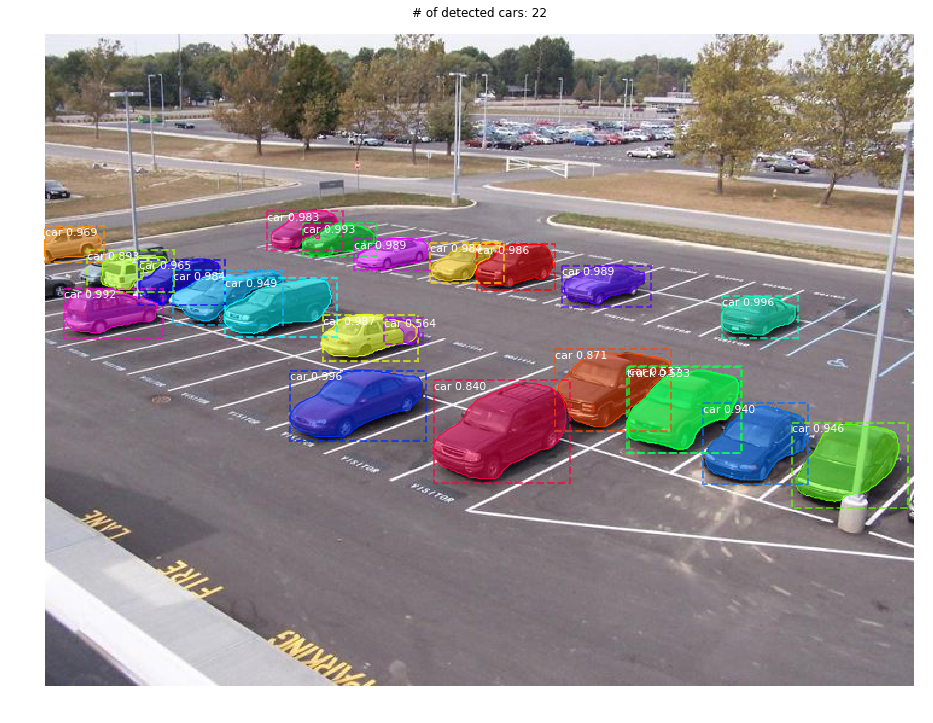

In [17]:
"""Visualize results."""
r = results[0]
r = filter_vehicles(r)
r = filter_small_vehicles(r, treshold=0.0018)

mrcnn.visualize.display_instances(
    image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'],
    title='# of detected cars: {}'.format(len(r['class_ids'])))